In [1]:
# imports

import json
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ncistd import visualize_3d_tensor, plot_factors_heatmap
from pathlib import Path
from sklearn.model_selection import ParameterGrid
import tensorly as tl
from tlab.cp_tensor import load_cp_tensor
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

# Collect data

In [4]:
# look at data

data_dir = Path('../../data/1-simulation/')
results_df = pd.read_csv(data_dir / 'cv_data_combined.csv')

results_df


,simulation_id,simulation_rank,simulation_shape,simulation_densities,simulation_mean_gene_sparsity,noise_level,rank,lambda,modeled_replicate,comparison_replicate,...,model_fms,true_fms,model_factor0_cosine_similarity,true_factor0_cosine_similarity,model_factor0_support_cosine_similarity,true_factor0_support_cosine_similarity,recovery,relevance,precision,recall
0,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,A,...,NaN,0.967317,NaN,0.975499,NaN,0.863145,0.74502,0.733815,0.996628,0.270695
1,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,B,...,0.998170,NaN,0.998267,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,C,...,0.998233,NaN,0.998324,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,B,...,NaN,0.970475,NaN,0.977646,NaN,0.863145,0.74502,0.733815,0.996628,0.270695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75595,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,B,B,...,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.00000,0.000000,0.000000,0.000000
75596,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,B,C,...,0.000000,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN
75597,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,C,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75598,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,C,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# separate out a dataframe of summary simulation information

# pull out simulation information
simulation_info_df = results_df[
    [
        'simulation_id', 
        'simulation_rank', 
        'simulation_shape', 
        'simulation_densities', 
        'simulation_mean_gene_sparsity', 
        'noise_level'
    ]
].drop_duplicates().reset_index(drop=True)
# separate out shape densities
simulation_info_df['mode0_length'] = [int(i[0]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
simulation_info_df['mode1_length'] = [int(i[1]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
simulation_info_df['mode2_length'] = [int(i[2]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
# separate out factor densities
simulation_info_df['factor0_density'] = [float(i[0]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df['factor1_density'] = [float(i[1]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df['factor2_density'] = [float(i[2]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df.drop(columns='simulation_densities', inplace=True)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101
1,1,2,"(425, 70, 16)",63.241735,2.214705,425,70,16,0.148804,0.401221,0.578969
2,2,3,"(840, 37, 85)",33.456900,3.012271,840,37,85,0.039830,0.894273,0.484237
3,3,9,"(368, 81, 68)",226.644577,6.271102,368,81,68,0.615882,0.713371,0.600264
4,4,7,"(257, 49, 38)",8.920292,0.248600,257,49,38,0.034709,0.757358,0.411906
...,...,...,...,...,...,...,...,...,...,...,...
95,95,7,"(476, 20, 38)",283.504017,0.693286,476,20,38,0.595597,0.976998,0.529082
96,96,7,"(572, 37, 87)",290.070242,0.401304,572,37,87,0.507116,0.837367,0.448428
97,97,2,"(855, 20, 57)",679.458620,0.850644,855,20,57,0.794688,0.125373,0.459051
98,98,3,"(261, 50, 73)",94.080418,0.386535,261,50,73,0.360461,0.902683,0.821287


In [6]:
# separate out ground truth data 
# compares models against simulation ground truth

gt_df = results_df[results_df['modeled_replicate'] == results_df['comparison_replicate']]
gt_df = gt_df[[
    'simulation_id', 'rank', 'lambda', 'modeled_replicate', 'n_components', 'mean_gene_sparsity', 'relative_sse', 
    'true_fms', 'true_factor0_cosine_similarity', 'true_factor0_support_cosine_similarity', 
    'recovery', 'relevance', 'precision', 'recall'
]].reset_index(drop=True)
# derived metrics
gt_df['recovery_relevance'] = (gt_df['recovery'] + gt_df['relevance']) / 2
gt_df['precision_recall'] = (gt_df['precision'] + gt_df['recall']) / 2

# generate separate dataframe for aggregated metrics
gt_df_agg = gt_df.groupby([
    'simulation_id', 
    'rank', 
    'lambda'
]).agg(
    gt_sse_mean=('relative_sse', 'mean'), 
    gt_fms_mean=('true_fms', 'mean'), 
    gt_cossim_f0_mean=('true_factor0_cosine_similarity', 'mean'), 
    gt_sup_cossim_f0_mean=('true_factor0_support_cosine_similarity', 'mean'), 
    gt_recovery_mean=('recovery', 'mean'), 
    gt_relevance_mean=('relevance', 'mean'), 
    gt_precision_mean=('precision', 'mean'), 
    gt_recall_mean=('recall', 'mean'), 
    gt_recovery_relevance_mean=('recovery_relevance', 'mean'), 
    gt_precision_recall_mean=('precision_recall', 'mean')
).reset_index()

gt_df_agg


,simulation_id,rank,lambda,gt_sse_mean,gt_fms_mean,gt_cossim_f0_mean,gt_sup_cossim_f0_mean,gt_recovery_mean,gt_relevance_mean,gt_precision_mean,gt_recall_mean,gt_recovery_relevance_mean,gt_precision_recall_mean
0,0,1,0.000,0.983290,0.968591,0.976368,0.863145,0.745020,0.733815,0.996628,0.270695,0.739417,0.633662
1,0,1,0.001,0.735574,0.969670,0.977118,0.863719,0.746011,0.733786,0.996723,0.269415,0.739899,0.633069
2,0,1,0.010,0.735577,0.969840,0.977240,0.865741,0.750007,0.730599,0.996906,0.262695,0.740303,0.629800
3,0,1,0.100,0.735899,0.971211,0.978171,0.870055,0.761947,0.710781,0.998145,0.219705,0.736364,0.608925
4,0,1,1.000,0.759847,0.960653,0.965729,0.892290,0.799675,0.548287,0.999779,0.089628,0.673981,0.544704
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,99,12,0.010,0.472049,0.847072,0.875315,0.991050,0.883654,0.982454,0.182506,1.000000,0.933054,0.591253
8396,99,12,0.100,0.476290,0.822771,0.868210,0.943198,0.781180,0.889728,0.313823,0.996955,0.835454,0.655389
8397,99,12,1.000,0.513676,0.673294,0.687190,0.708684,0.298802,0.505098,0.847933,0.603300,0.401950,0.725617
8398,99,12,10.000,0.989646,0.138699,0.187597,0.135963,0.006438,0.026764,1.000000,0.001024,0.016601,0.500512


In [7]:
# separate out cross validation data
# compares each model fit to one replicate against models fit to the other two replicates

cv_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]
cv_df = cv_df[[
    'simulation_id', 'rank', 'lambda', 'modeled_replicate', 'comparison_replicate', 
    'replicate_pair', 'n_components', 'mean_gene_sparsity', 'relative_sse', 
    'model_fms', 'model_factor0_cosine_similarity', 'model_factor0_support_cosine_similarity'
]].reset_index(drop=True)

# generate separate dataframe for aggregated metrics
cv_df_agg = cv_df.groupby([
    'simulation_id', 
    'rank', 
    'lambda'
]).agg(
    cv_sse_mean=('relative_sse', 'mean'), 
    cv_sse_sem=('relative_sse', 'sem'), 
    cv_fms_mean=('model_fms', 'mean'), 
    cv_fms_sem=('model_fms', 'sem'), 
    cv_f0_cossim_mean=('model_factor0_support_cosine_similarity', 'mean'), 
    cv_f0_cossim_sem=('model_factor0_support_cosine_similarity', 'sem')
).reset_index()

cv_df_agg


,simulation_id,rank,lambda,cv_sse_mean,cv_sse_sem,cv_fms_mean,cv_fms_sem,cv_f0_cossim_mean,cv_f0_cossim_sem
0,0,1,0.000,0.983319,0.000010,0.998262,0.000063,1.000000,0.000000
1,0,1,0.001,0.736474,0.000280,0.998272,0.000066,0.998670,0.000333
2,0,1,0.010,0.736475,0.000278,0.998271,0.000065,0.992618,0.000348
3,0,1,0.100,0.736774,0.000259,0.998245,0.000062,0.976282,0.003279
4,0,1,1.000,0.760569,0.000159,0.997552,0.000102,0.979631,0.001978
...,...,...,...,...,...,...,...,...,...
8395,99,12,0.010,0.559601,0.001108,0.234426,0.006233,0.847801,0.016732
8396,99,12,0.100,0.550070,0.001376,0.295733,0.010367,0.731324,0.008724
8397,99,12,1.000,0.544560,0.000611,0.282848,0.010625,0.342556,0.008866
8398,99,12,10.000,0.990344,0.000367,0.204192,0.019153,0.189876,0.035500


In [8]:
cv_df_agg[(cv_df_agg['simulation_id'] == 5) & (cv_df_agg['rank'] == 1)]

,simulation_id,rank,lambda,cv_sse_mean,cv_sse_sem,cv_fms_mean,cv_fms_sem,cv_f0_cossim_mean,cv_f0_cossim_sem
420,5,1,0.000,0.985911,0.003225,0.231230,0.231230,1.000000,0.000000
421,5,1,0.001,1.000142,0.011355,0.231534,0.231534,0.320256,0.320256
422,5,1,0.010,1.000054,0.011329,0.231214,0.231214,0.296296,0.296296
423,5,1,0.100,0.999246,0.011336,0.229612,0.229612,0.304290,0.304290
424,5,1,1.000,0.993552,0.011046,0.222439,0.222439,0.223607,0.223607
425,5,1,10.000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
426,5,1,100.000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Define optimal rank

The rank of the model with the minimum SSE value, excluding all models fit without a sparsity penalty (lambda=0)

In [9]:
# find the optimal rank parameter for each simulation based on minimum sse

# drop the lambda=0 data, since this does not always show a minimum
rank_optima_df = cv_df[cv_df['lambda'] != 0]
# select the sse minimum for each simulation
rank_optima_df = rank_optima_df.loc[rank_optima_df.groupby('simulation_id').relative_sse.idxmin(), :]
# map optimal rank back to simulation_info_df
rank_optima = rank_optima_df.set_index('simulation_id')['rank']
simulation_info_df['optimal_rank'] = simulation_info_df['simulation_id'].map(rank_optima)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,optimal_rank
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101,8
1,1,2,"(425, 70, 16)",63.241735,2.214705,425,70,16,0.148804,0.401221,0.578969,2
2,2,3,"(840, 37, 85)",33.456900,3.012271,840,37,85,0.039830,0.894273,0.484237,3
3,3,9,"(368, 81, 68)",226.644577,6.271102,368,81,68,0.615882,0.713371,0.600264,9
4,4,7,"(257, 49, 38)",8.920292,0.248600,257,49,38,0.034709,0.757358,0.411906,7
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,7,"(476, 20, 38)",283.504017,0.693286,476,20,38,0.595597,0.976998,0.529082,7
96,96,7,"(572, 37, 87)",290.070242,0.401304,572,37,87,0.507116,0.837367,0.448428,7
97,97,2,"(855, 20, 57)",679.458620,0.850644,855,20,57,0.794688,0.125373,0.459051,2
98,98,3,"(261, 50, 73)",94.080418,0.386535,261,50,73,0.360461,0.902683,0.821287,3


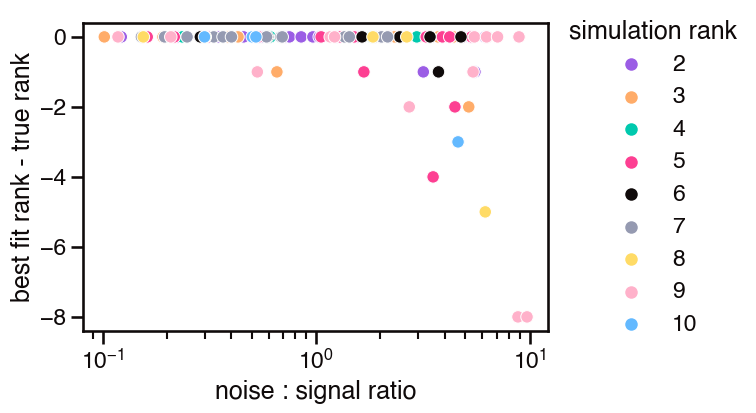

In [11]:
# plot true rank vs. optimal rank

# arrange data for plotting
rank_plot_df = simulation_info_df.copy()
rank_plot_df['min_cv_sse'] = rank_plot_df['simulation_id'].map(
    rank_optima_df.set_index('simulation_id')['relative_sse']
)
rank_plot_df['best fit rank - true rank'] = rank_plot_df['optimal_rank'] - rank_plot_df['simulation_rank']
rank_plot_df = rank_plot_df.sort_values(['simulation_rank', 'noise_level']).reset_index(drop=True)
rank_plot_df['simulation_rank'] = rank_plot_df['simulation_rank'].astype(str)

# create plot
fig_1a, ax_1a = plt.subplots(figsize=[6, 4])
sns.scatterplot(
    x='noise_level', 
    y='best fit rank - true rank', 
    hue='simulation_rank', 
    alpha=1.0, 
    data=rank_plot_df, 
    ax=ax_1a
)
plt.xlabel('noise : signal ratio');
plt.xscale('log')
plt.legend(title='simulation rank', loc='center left', bbox_to_anchor=[1, .5]);
plt.savefig('optimal_rank_v_noise.png', bbox_inches='tight')


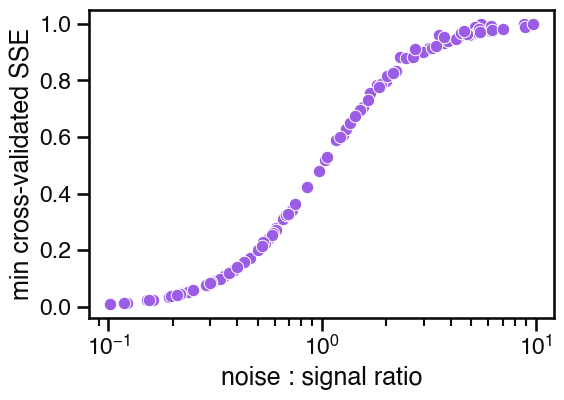

In [9]:
# plot relative sse of best cv replicate vs noise

# make plot
fig_s1, ax_s1 = plt.subplots(figsize=[6, 4])
sns.scatterplot(
    x='noise_level', 
    y='min_cv_sse', 
    color=sns.color_palette()[0], 
    data=rank_plot_df, 
    ax=ax_s1
);
plt.xlabel('noise : signal ratio');
plt.ylabel('min cross-validated SSE');
plt.xscale('log')
# plt.savefig('../figures/best_sse_v_noise.png')


# Define optimal sparsity

Measure models against true factors

Metrics to look at cluster membership of mode-0 factor matrix:
* Cosine similarity of support of factor-0
* Precision-recall of factor-0

Metrics that incorporate weight values (don't explicitly measure sparsity):
* Cosine similarity of factor-0 
* FMS (imperfect)

Compare how similar these are to one another


In [47]:
# find optimal lambda values based on cosine similarity (of values and support), precision-recall, and FMS

# make dataframe to store results
optimal_lambda_df = simulation_info_df.copy()
optimal_lambda_df['log noise:signal'] = np.log10(optimal_lambda_df['noise_level'])

# set up dataframe for selecting best lambda
lambda_df = gt_df_agg.copy()
lambda_df['optimal_rank'] = lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
lambda_df = lambda_df[lambda_df['rank'] == lambda_df['optimal_rank']].reset_index(drop=True)
# sort by descending lambda value so that if there is a tie in the score, the highest lambda value is picked
lambda_df = lambda_df.sort_values(['simulation_id', 'lambda'], ascending=False)

# set up naming conventions
# CSS = cosine similarity score, SCSS = support cosine similary score, MPRS = mean precision recall score
variables = [
    ('gt_fms_mean', 'fms'), 
    ('gt_cossim_f0_mean', 'css_f0'), 
    ('gt_precision_mean', 'precision'), 
    ('gt_recall_mean', 'recall'), 
    ('gt_precision_recall_mean', 'mprs'), 
    ('gt_sup_cossim_f0_mean', 'scss_f0')
]

# collect the max scores for each metric, along with the lambda values of the max
for (metric, var_name) in variables:
    # find max value of metric
    metric_df = lambda_df.loc[lambda_df.groupby('simulation_id')[metric].idxmax(), :]
    optimal_lambda_df['max_{}'.format(var_name)] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')[metric]
    )
    optimal_lambda_df['lambda_max_{}'.format(var_name)] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')['lambda']
    )

optimal_lambda_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,...,max_css_f0,lambda_max_css_f0,max_precision,lambda_max_precision,max_recall,lambda_max_recall,max_mprs,lambda_max_mprs,max_scss_f0,lambda_max_scss_f0
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,...,0.989917,0.010,0.998648,1.0,1.0,0.000,0.929255,0.10,0.939429,0.10
1,1,2,"(425, 70, 16)",63.241735,2.214705,425,70,16,0.148804,0.401221,...,0.988128,0.100,1.000000,10.0,1.0,0.010,0.901006,1.00,0.946657,1.00
2,2,3,"(840, 37, 85)",33.456900,3.012271,840,37,85,0.039830,0.894273,...,0.994424,1.000,1.000000,10.0,1.0,0.100,0.785762,1.00,0.861565,1.00
3,3,9,"(368, 81, 68)",226.644577,6.271102,368,81,68,0.615882,0.713371,...,0.962817,1.000,0.995765,10.0,1.0,0.010,0.743772,1.00,0.801578,1.00
4,4,7,"(257, 49, 38)",8.920292,0.248600,257,49,38,0.034709,0.757358,...,0.999897,0.100,1.000000,1.0,1.0,0.010,0.953846,1.00,0.974741,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,7,"(476, 20, 38)",283.504017,0.693286,476,20,38,0.595597,0.976998,...,0.997100,0.100,0.999362,10.0,1.0,0.001,0.895086,1.00,0.929117,1.00
96,96,7,"(572, 37, 87)",290.070242,0.401304,572,37,87,0.507116,0.837367,...,0.999804,0.100,1.000000,10.0,1.0,0.010,0.952572,1.00,0.974665,1.00
97,97,2,"(855, 20, 57)",679.458620,0.850644,855,20,57,0.794688,0.125373,...,0.992887,0.010,1.000000,1.0,1.0,0.000,0.916523,0.10,0.951508,0.10
98,98,3,"(261, 50, 73)",94.080418,0.386535,261,50,73,0.360461,0.902683,...,0.999943,0.100,1.000000,10.0,1.0,0.010,0.964848,1.00,0.981530,1.00


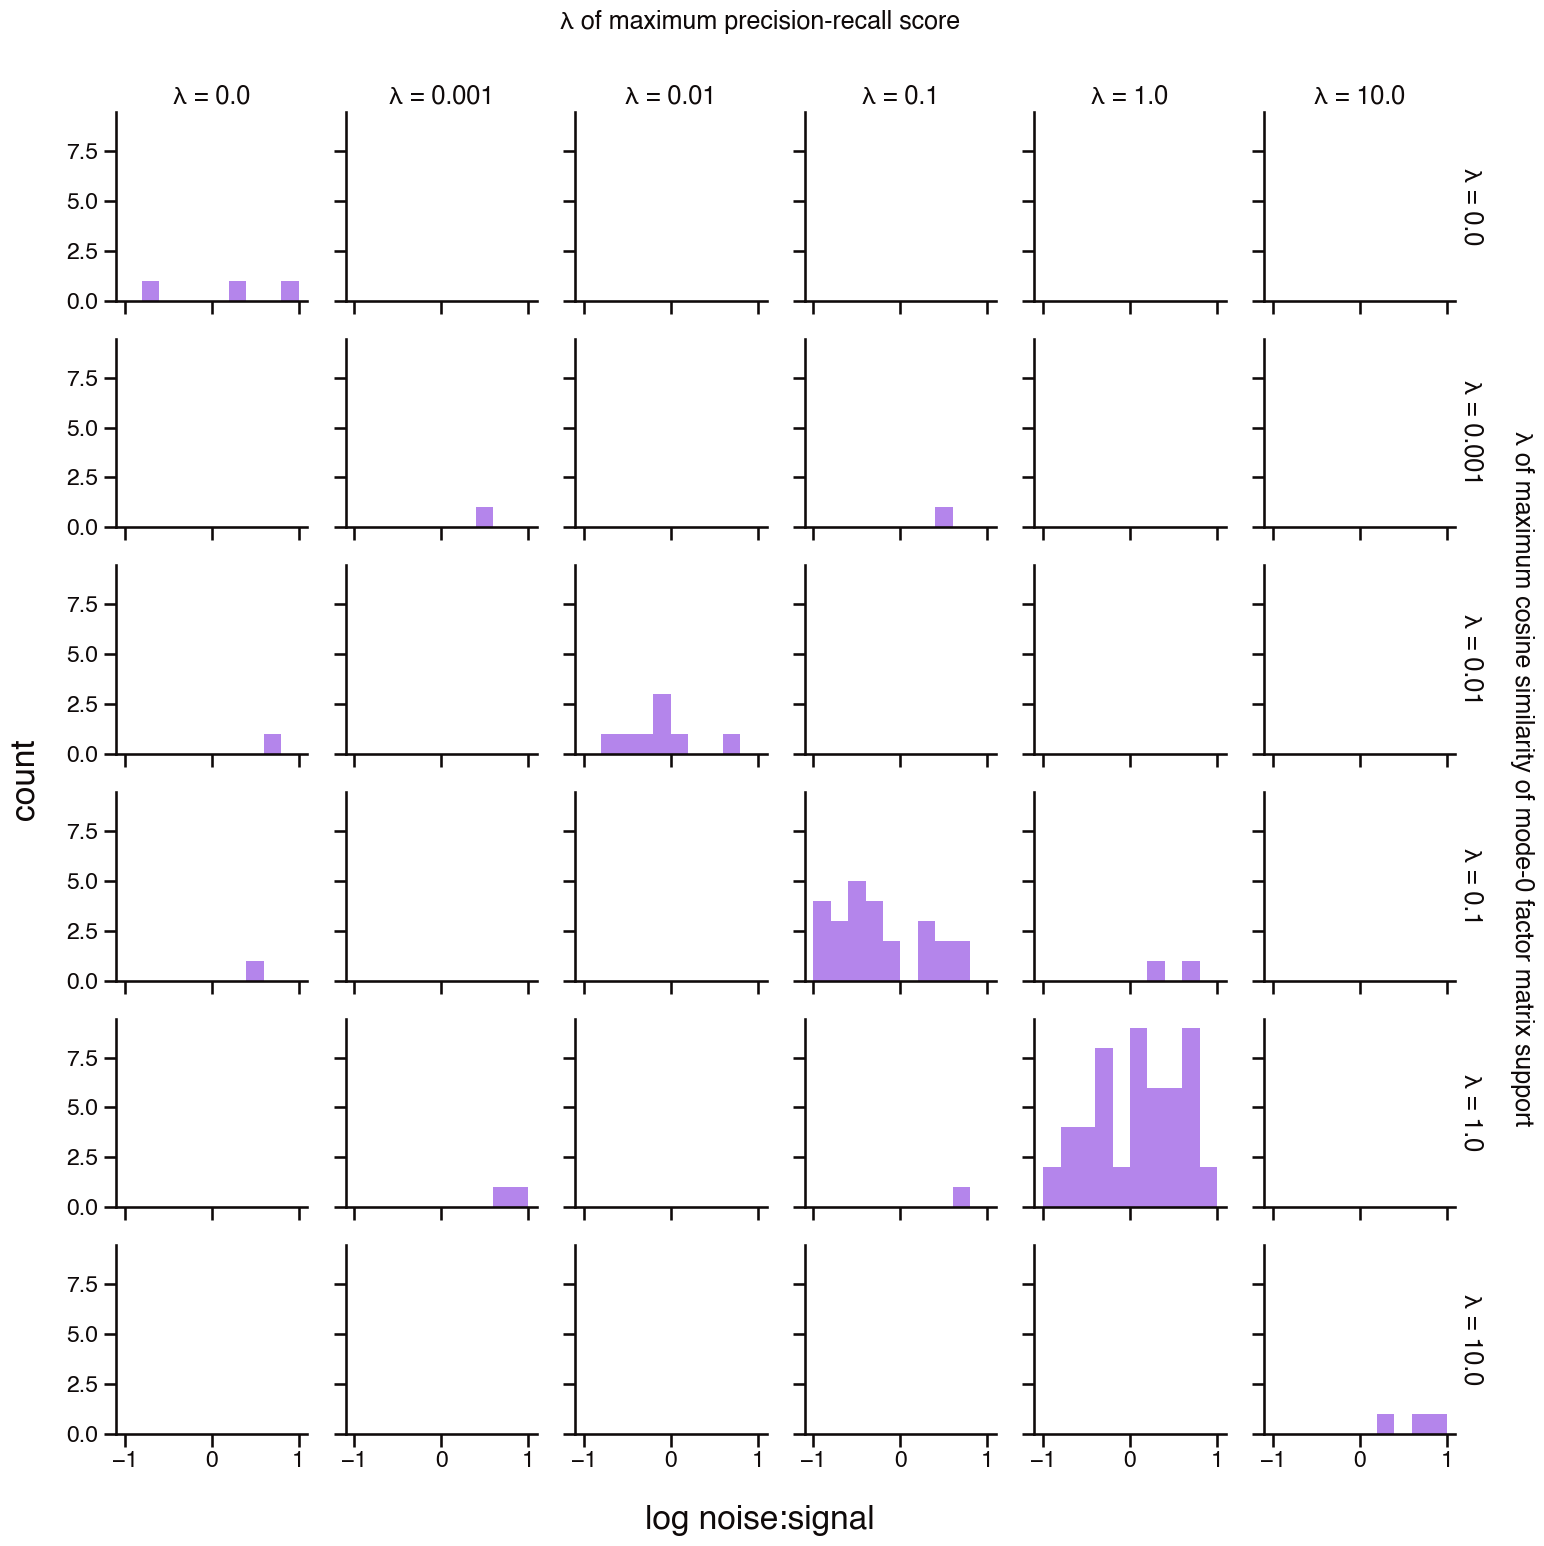

In [48]:
# plot a histogram grid comparing optimal lambdas according to precision recall & support cosine similarity

# parameterize FacetGrid
g = sns.FacetGrid(
    optimal_lambda_df, 
    row='lambda_max_scss_f0', 
    col='lambda_max_mprs', 
    margin_titles=True, 
    height=2.5
)

# plot data
g.map(sns.histplot, 'log noise:signal', color=sns.color_palette()[0], bins=10, binrange=(-1, 1));
# g.map(sns.histplot, 'factor0_density', color=sns.color_palette()[1], bins=10, binrange=(0, 1));
# g.map(sns.histplot, 'mode0_length', color=sns.color_palette()[2], bins=10, binrange=(0, 1000));

# adjust figure
g.figure.subplots_adjust(wspace=.2, hspace=.2)
g.set_titles(row_template='λ = {row_name}', col_template='λ = {col_name}');
# g.set_axis_labels('log noise:signal', 'count')
g.set_axis_labels('', '')
g.fig.text(.5, 0, ha='center', s='log noise:signal', fontdict={'fontsize':24});
g.fig.text(0, .5, rotation=90, va='center', s='count', fontdict={'fontsize':24});
g.fig.text(.5, 1, ha='center', s='λ of maximum precision-recall score');
g.fig.text(1, .5, rotation=270, va='center', s='λ of maximum cosine similarity of mode-0 factor matrix support');


In [177]:
# resolve ground truth optimal target lambda for each simulation

# for 8 simulations in which MPRS and SCSS don't agree, break the tie by choosing the lambda value
# corresponding to the higher precision score, which happens to be the higher of the two lambdas in each case 
# (the sparser solution)
optimal_lambda_df['optimal_lambda'] = np.max(
    [optimal_lambda_df['lambda_max_mprs'], optimal_lambda_df['lambda_max_scss_f0']], axis=0
)
# map back to simulation_info_df
simulation_info_df['optimal_lambda'] = simulation_info_df['simulation_id'].map(
    optimal_lambda_df.set_index('simulation_id')['optimal_lambda']
)

optimal_lambda_df[optimal_lambda_df['lambda_max_mprs'] != optimal_lambda_df['lambda_max_scss_f0']]


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,...,lambda_min_cv_sse_1se,lambda_max_cv_fms_1se,min_cv_sse,lambda_min_cv_sse,max_cv_fms,lambda_max_cv_fms,sse_inflection,lambda_sse_inflection,fms_inflection,lambda_fms_inflection
15,15,3,"(333, 14, 32)",160.864731,5.179153,333,14,32,0.483077,0.558017,...,1.0,0.10,0.990162,1.0,0.582584,0.001,0.012379,1.0,-0.477643,1.0
25,25,8,"(184, 79, 19)",174.835567,2.654867,184,79,19,0.950193,0.533428,...,0.1,0.10,0.884279,0.1,0.896414,0.010,0.090899,1.0,-0.247933,1.0
28,28,2,"(309, 84, 96)",289.856795,3.173706,309,84,96,0.938048,0.031931,...,0.1,0.10,0.914864,0.1,0.963561,0.001,0.074908,1.0,-0.435931,1.0
33,33,7,"(983, 37, 36)",420.494436,2.023802,983,37,36,0.427766,0.090858,...,0.1,0.10,0.816124,0.1,0.902063,0.100,0.153735,1.0,-0.347603,1.0
48,48,9,"(365, 42, 72)",74.233201,8.804168,365,42,72,0.203379,0.064748,...,1.0,1.00,0.998868,1.0,0.534681,0.100,0.001527,1.0,-0.493591,1.0
62,62,10,"(783, 32, 71)",724.086362,4.613912,783,32,71,0.924759,0.468251,...,1.0,0.01,0.974879,1.0,0.655531,0.010,0.027518,1.0,-0.457278,1.0
84,84,8,"(692, 10, 44)",33.989934,6.187579,692,10,44,0.049118,0.917514,...,1.0,1.00,0.994459,1.0,0.397157,1.000,0.010947,1.0,-0.286792,1.0
91,91,2,"(679, 64, 47)",601.982530,6.176310,679,64,47,0.886572,0.495475,...,1.0,0.10,0.975942,0.1,0.946825,0.100,0.010146,1.0,-0.773897,10.0


# Compare methods of picking optimal sparsity

Within the optimal rank, find lambda corresponding to:
* Minimum of cross-validated SSE
* Inflection point of cross-validated SSE (maximum change in slope)
* Maximum of cross-validated FMS
* Inflection point of cross-validated FMS (minimum change in slope)
* Maximum lambda within n standard deviations of minimum cross-validated SSE 
* Maximum lambda within n standard deviations of maximum cross-validated FMS 

Score as sum of absolute values of difference between log(selected lambda) and log(optimal lambda)


In [150]:
# find optima of different selection criteria based on cross-validated scoring metrics

# set up dataframe for selecting best lambda based on cross validation data
cv_lambda_df = cv_df_agg.copy()
cv_lambda_df['optimal_rank'] = cv_lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
cv_lambda_df = cv_lambda_df[cv_lambda_df['rank'] == cv_lambda_df['optimal_rank']]

# drop lambda=0 values, under the assumption that at least some regularization will be imposed on the model
cv_lambda_df = cv_lambda_df[cv_lambda_df['lambda'] != 0].reset_index(drop=True)

# calculate inflection points for SSE and FMS
for simid in cv_lambda_df.simulation_id.unique():
    # find SSE inflection point
    sse_vector = cv_lambda_df[cv_lambda_df['simulation_id'] == simid].sort_values('lambda')['cv_sse_mean']
    d2ydx_sse = np.pad(np.diff(np.diff(sse_vector)), 1, constant_values=np.nan)
    cv_lambda_df.loc[sse_vector.index, 'd2ydx_sse'] = d2ydx_sse
    # find FMS inflection point
    fms_vector = cv_lambda_df[cv_lambda_df['simulation_id'] == simid].sort_values('lambda')['cv_fms_mean']
    d2ydx_fms = np.pad(np.diff(np.diff(fms_vector)), 1, constant_values=np.nan)
    cv_lambda_df.loc[fms_vector.index, 'd2ydx_fms'] = d2ydx_fms
    
# sort by descending lambda value so that if there is a tie in the score, the highest lambda value is picked
cv_lambda_df = cv_lambda_df.sort_values(['simulation_id', 'lambda'], ascending=False)  

# for each simulation, calculate max lambda corresponding to SSE <= to min(SSE) + SEM(min(SSE))
metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')['cv_sse_mean'].idxmin(), :]
metric_optima_1se = dict(zip(metric_df['simulation_id'], metric_df['cv_sse_mean'] + metric_df['cv_sse_sem']))
cv_lambda_df['min_cv_sse_1se'] = cv_lambda_df['simulation_id'].map(metric_optima_1se)
# for each simulation, select only models where SSE <= to min(SSE) + SEM(min(SSE))
valid_options_df = cv_lambda_df[cv_lambda_df['cv_sse_mean'].le(cv_lambda_df['min_cv_sse_1se'])]
# within candidates, find max lambda
max_lambda_df = valid_options_df.loc[valid_options_df.groupby('simulation_id')['lambda'].idxmax(), :]
# map optimal lambda back
optimal_lambda_df['lambda_min_cv_sse_1se'] = optimal_lambda_df['simulation_id'].map(
    max_lambda_df.set_index('simulation_id')['lambda']
)

# for each simulation, calculate max lambda corresponding to FMS >= to max(FMS) - SEM(max(FMS))
metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')['cv_fms_mean'].idxmax(), :]
metric_optima_1se = dict(zip(metric_df['simulation_id'], metric_df['cv_fms_mean'] - metric_df['cv_fms_sem']))
cv_lambda_df['max_cv_fms_1se'] = cv_lambda_df['simulation_id'].map(metric_optima_1se)
# for each simulation, select only models where FMS >= to max(FMS) - SEM(max(FMS))
valid_options_df = cv_lambda_df[cv_lambda_df['cv_fms_mean'].ge(cv_lambda_df['max_cv_fms_1se'])]
# within candidates, find max lambda
max_lambda_df = valid_options_df.loc[valid_options_df.groupby('simulation_id')['lambda'].idxmax(), :]
# map optimal lambda back
optimal_lambda_df['lambda_max_cv_fms_1se'] = optimal_lambda_df['simulation_id'].map(
    max_lambda_df.set_index('simulation_id')['lambda']
)

# put together selection metrics
selection_metrics = [
    ('cv_sse_mean', 'min_cv_sse', 'min'), 
    ('cv_fms_mean', 'max_cv_fms', 'max'), 
    ('d2ydx_sse', 'sse_inflection', 'max'), 
    ('d2ydx_fms', 'fms_inflection', 'min')
]

for (metric, label, optimum) in selection_metrics:
    if optimum == 'min':
        metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')[metric].idxmin(), :]
    elif optimum == 'max':
        metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')[metric].idxmax(), :]
    optimal_lambda_df[label] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')[metric]
    )
    optimal_lambda_df['lambda_{}'.format(label)] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')['lambda']
    )

optimal_lambda_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,...,lambda_min_cv_sse_1se,lambda_max_cv_fms_1se,min_cv_sse,lambda_min_cv_sse,max_cv_fms,lambda_max_cv_fms,sse_inflection,lambda_sse_inflection,fms_inflection,lambda_fms_inflection
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,...,0.01,0.01,0.087495,0.01,0.979923,0.001,0.617043,1.0,-0.992174,1.0
1,1,2,"(425, 70, 16)",63.241735,2.214705,425,70,16,0.148804,0.401221,...,0.10,1.00,0.835865,0.10,0.965842,0.100,0.139185,1.0,-0.575190,1.0
2,2,3,"(840, 37, 85)",33.456900,3.012271,840,37,85,0.039830,0.894273,...,1.00,1.00,0.903435,1.00,0.974733,1.000,0.037331,1.0,-0.939460,10.0
3,3,9,"(368, 81, 68)",226.644577,6.271102,368,81,68,0.615882,0.713371,...,1.00,1.00,0.977159,1.00,0.905625,1.000,0.013197,10.0,-0.834641,10.0
4,4,7,"(257, 49, 38)",8.920292,0.248600,257,49,38,0.034709,0.757358,...,0.10,1.00,0.058862,0.10,0.998547,0.100,0.580439,1.0,-0.601060,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,7,"(476, 20, 38)",283.504017,0.693286,476,20,38,0.595597,0.976998,...,0.10,1.00,0.327441,0.10,0.995162,1.000,0.447566,1.0,-0.876179,10.0
96,96,7,"(572, 37, 87)",290.070242,0.401304,572,37,87,0.507116,0.837367,...,0.10,1.00,0.139040,0.10,0.999615,1.000,0.307791,1.0,-0.998381,10.0
97,97,2,"(855, 20, 57)",679.458620,0.850644,855,20,57,0.794688,0.125373,...,0.10,0.10,0.426423,0.01,0.985172,0.100,0.498036,1.0,-0.974906,1.0
98,98,3,"(261, 50, 73)",94.080418,0.386535,261,50,73,0.360461,0.902683,...,0.10,1.00,0.130281,0.10,0.999833,1.000,0.548748,10.0,-0.999674,10.0


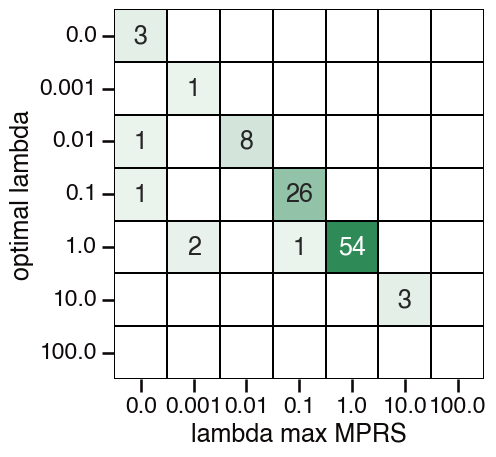

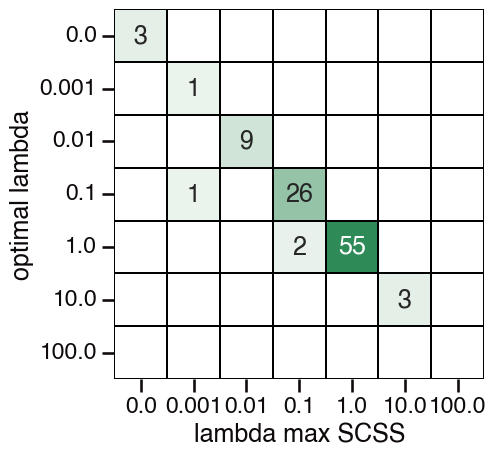

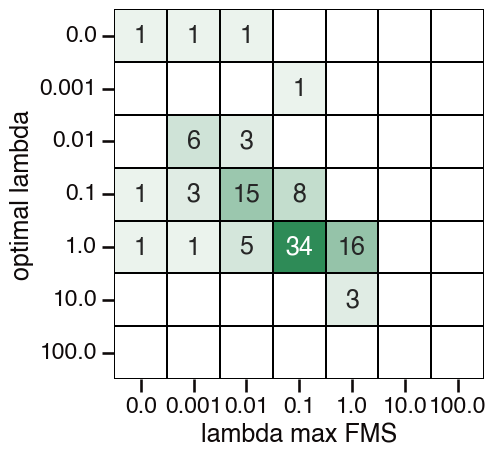

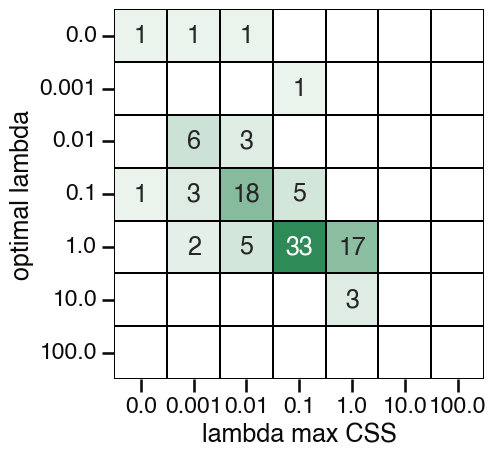

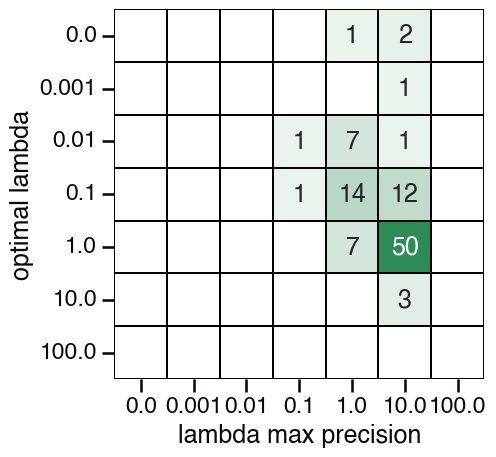

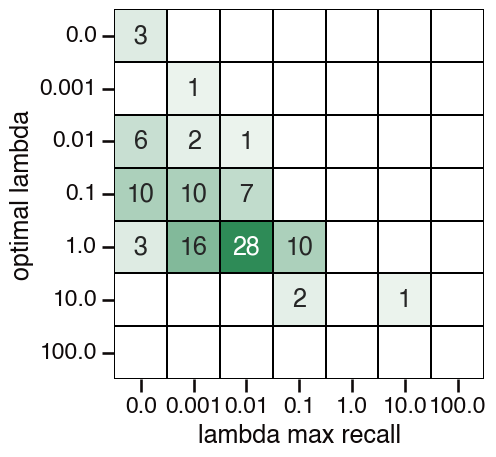

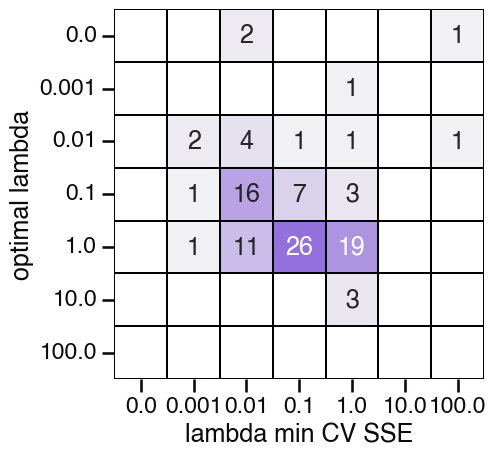

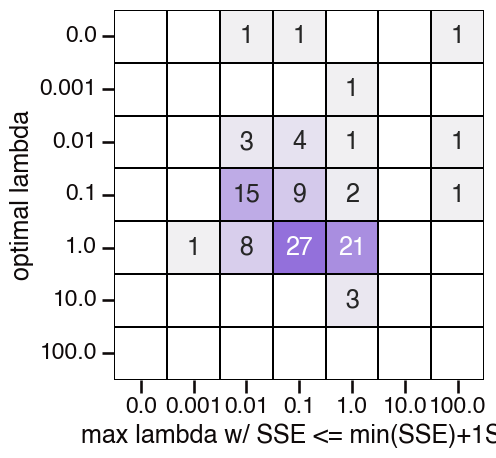

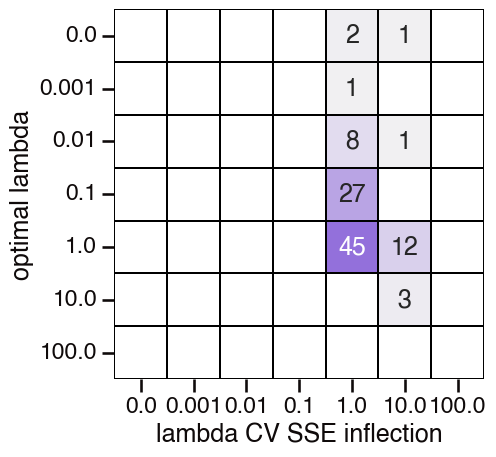

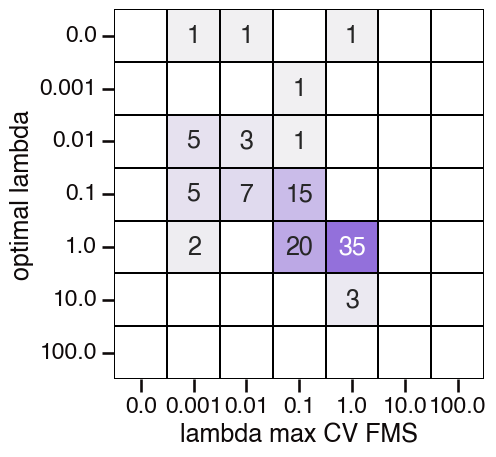

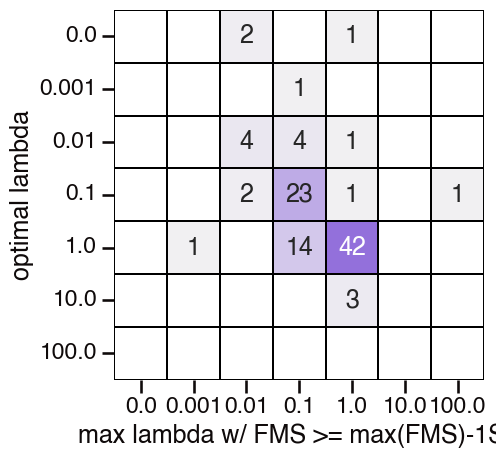

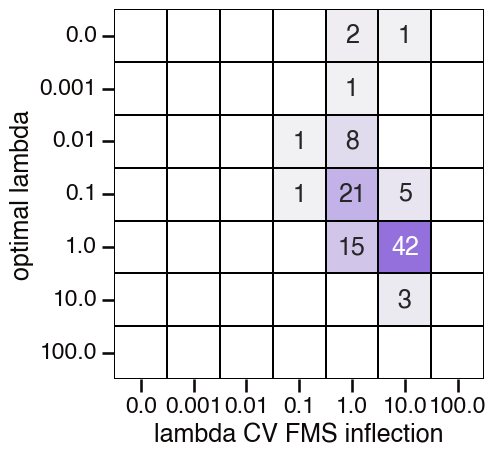

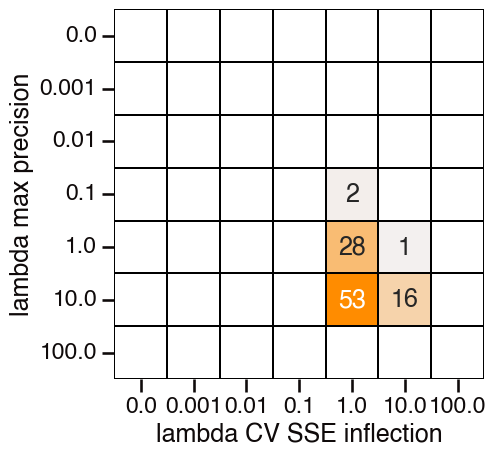

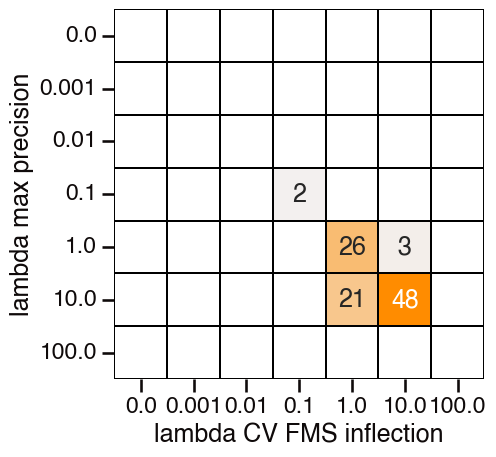

In [242]:
# make heatmap comparing optimal lambda values with methods of identification

# make template dataframe to house heatmap data
lambdas = results_df['lambda'].unique()
template_lambda_counts_df = pd.DataFrame(columns=lambdas, index=lambdas).fillna(0).astype(int)

# set up metrics to look at
comparison_values = [
    ('optimal_lambda', 'optimal lambda', 'lambda_max_mprs', 'lambda max MPRS', 'gt'), 
    ('optimal_lambda', 'optimal lambda', 'lambda_max_scss_f0', 'lambda max SCSS', 'gt'), 
    ('optimal_lambda', 'optimal lambda', 'lambda_max_fms', 'lambda max FMS', 'gt'), 
    ('optimal_lambda', 'optimal lambda', 'lambda_max_css_f0', 'lambda max CSS', 'gt'), 
    ('optimal_lambda', 'optimal lambda', 'lambda_max_precision', 'lambda max precision', 'gt'), 
    ('optimal_lambda', 'optimal lambda', 'lambda_max_recall', 'lambda max recall', 'gt'), 
    ('optimal_lambda', 'optimal lambda', 'lambda_min_cv_sse', 'lambda min CV SSE', 'cv'),     
    ('optimal_lambda', 'optimal lambda', 'lambda_min_cv_sse_1se', 'max lambda w/ SSE <= min(SSE)+1SE', 'cv'),
    ('optimal_lambda', 'optimal lambda', 'lambda_sse_inflection', 'lambda CV SSE inflection', 'cv'),     
    ('optimal_lambda', 'optimal lambda', 'lambda_max_cv_fms', 'lambda max CV FMS', 'cv'), 
    ('optimal_lambda', 'optimal lambda', 'lambda_max_cv_fms_1se', 'max lambda w/ FMS >= max(FMS)-1SE', 'cv'),
    ('optimal_lambda', 'optimal lambda', 'lambda_fms_inflection', 'lambda CV FMS inflection', 'cv'), 
    ('lambda_max_precision', 'lambda max precision', 'lambda_sse_inflection', 'lambda CV SSE inflection', 'other'), 
    ('lambda_max_precision', 'lambda max precision', 'lambda_fms_inflection', 'lambda CV FMS inflection', 'other')
]

# iterate through plots
for (col1, label1, col2, label2, dtype) in comparison_values:
    # arrange plot data
    plot_df = template_lambda_counts_df.copy()
    data_df = optimal_lambda_df[[col1, col2]].value_counts()
    for i, value in zip(data_df.index, data_df.values):
        plot_df.loc[i[0], i[1]] = value

    # set colormap based on datatype
    if dtype == 'gt':
        cmap = sns.color_palette('light:seagreen', as_cmap=True)
    elif dtype == 'cv':
        cmap = sns.color_palette('light:mediumpurple', as_cmap=True)
    else:
        cmap = sns.color_palette('light:darkorange', as_cmap=True)
        
    # make heatmap
    sns.heatmap(
        plot_df, 
        cmap=cmap, 
        annot=True, 
        linecolor='black', 
        linewidths=0.01, 
        cbar=False, 
        square=True, 
        mask=(plot_df == 0), 
    );
    plt.yticks(rotation=0)
    plt.xlabel(label2);
    plt.ylabel(label1);
    plt.show()
    

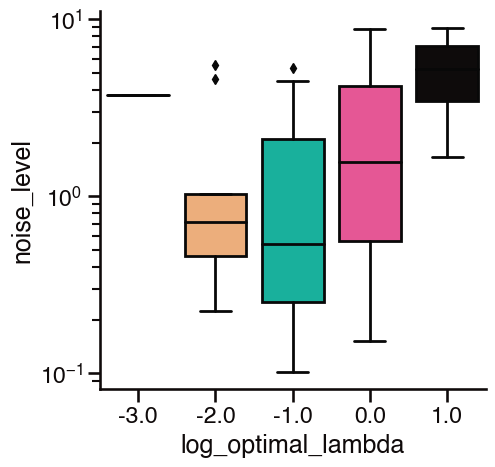

In [259]:
# plot optimal lambda vs noise level

plot_df = optimal_lambda_df[optimal_lambda_df['optimal_lambda'] != 0]
plot_df = plot_df.sort_values('optimal_lambda')
plot_df['log_optimal_lambda'] = np.log10(plot_df['optimal_lambda']).astype(str)
# fig, ax = plt.subplots(figsize=[6, 4])
sns.catplot(
    x='log_optimal_lambda', 
    y='noise_level', 
    data=plot_df, 
    kind='box'
)
plt.yscale('log')


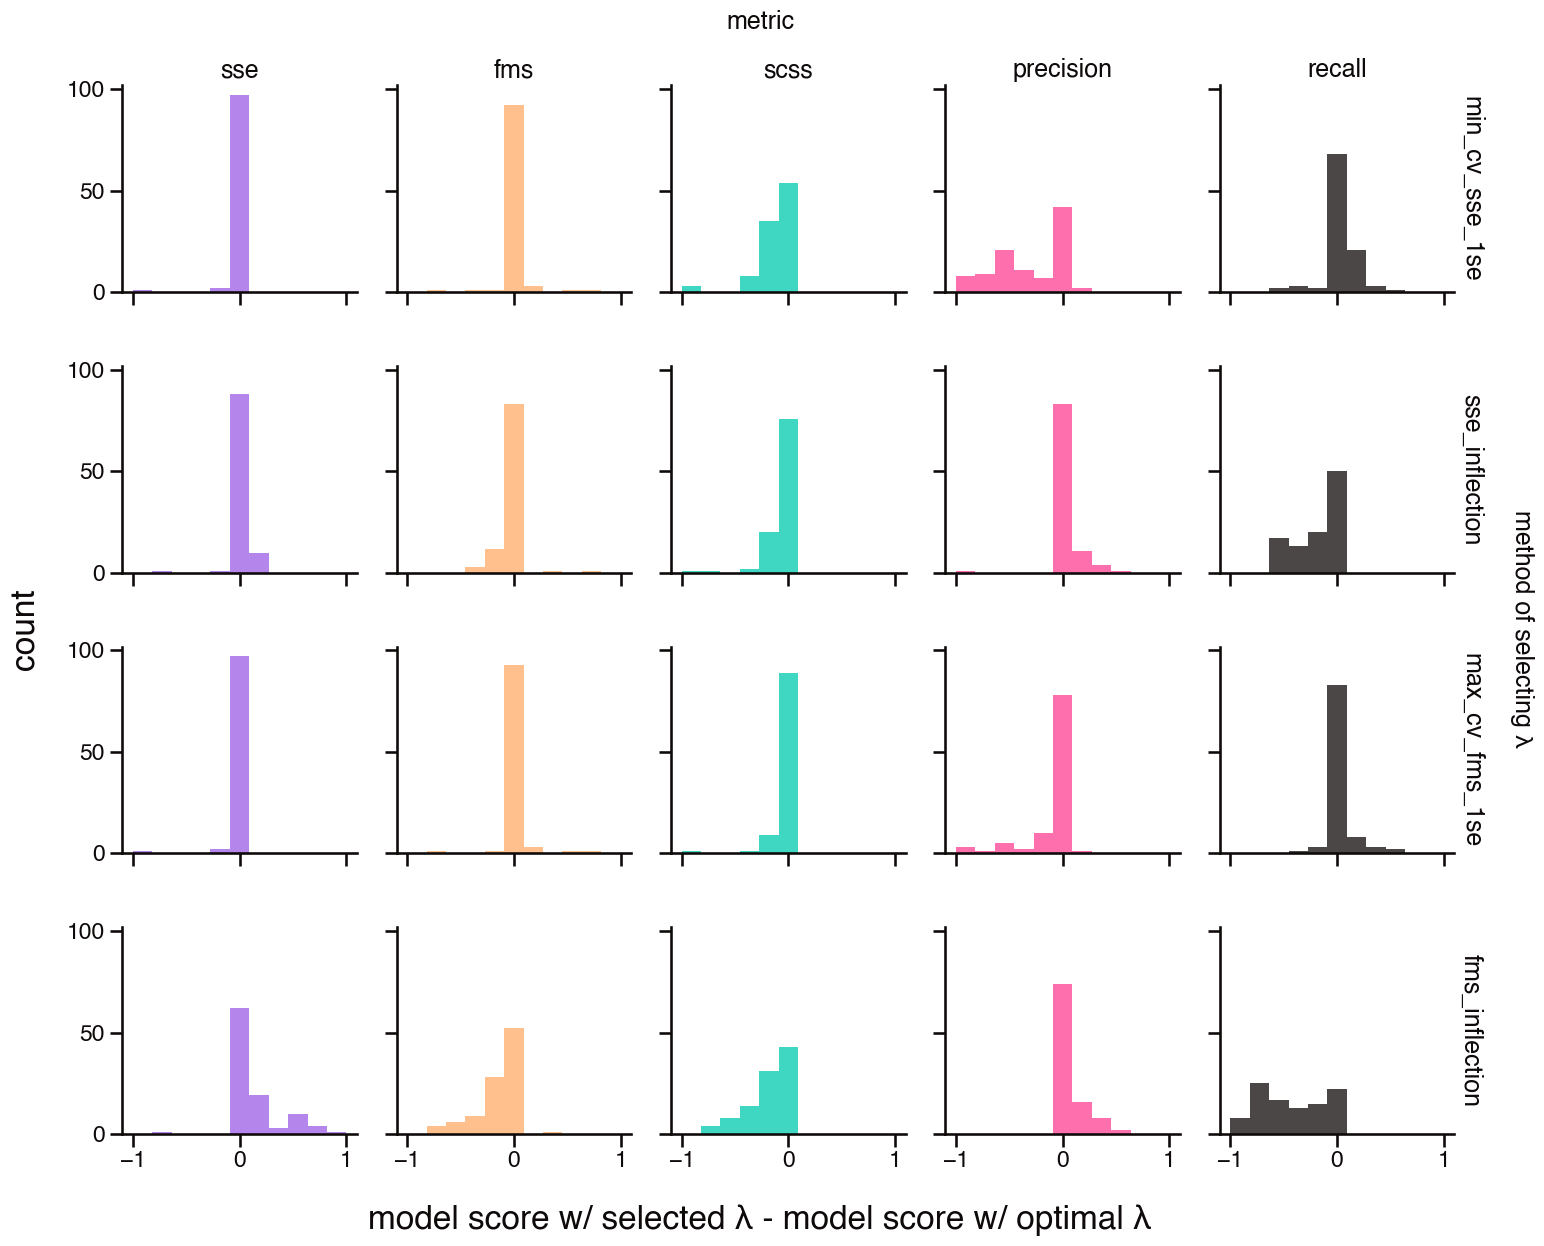

In [268]:
# look at difference between selected sparsity and optimal sparsity on a number of different metrics

# start with aggregated ground truth data
lambda_summary_df = gt_df_agg.copy()
# map back optimal rank and lambda, as well as noise
lambda_summary_df['optimal_rank'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
lambda_summary_df['optimal_lambda'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_lambda']
)
lambda_summary_df['noise_level'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['noise_level']
)
# down-select to just optimal rank models
lambda_summary_df = lambda_summary_df[
    lambda_summary_df['rank'] == lambda_summary_df['optimal_rank']
].reset_index(drop=True)

# organize naming conventions for metrics
gt_metrics = ['gt_sse_mean', 'gt_fms_mean', 'gt_sup_cossim_f0_mean', 'gt_precision_mean', 'gt_recall_mean']
metrics = ['sse', 'fms', 'scss', 'precision', 'recall']

# collect metrics 
gt_optimal_models_df = lambda_summary_df[
    lambda_summary_df['lambda'] == lambda_summary_df['optimal_lambda']
].reset_index(drop=True).rename(columns={
    k: f'{v}_optimal_lambda' for (k, v) in zip(gt_metrics, metrics)
}).drop(columns=['rank', 'lambda', 'optimal_rank', 'optimal_lambda', 'noise_level', 
                 'gt_recovery_mean', 'gt_relevance_mean', 'gt_recovery_relevance_mean'])

# add metrics for each method of selecting sparsity level
methods = [
#     'min_cv_sse', 
    'min_cv_sse_1se', 
    'sse_inflection', 
#     'max_cv_fms', 
    'max_cv_fms_1se', 
    'fms_inflection'
]

# compile methods comparison df
methods_comparison_df = pd.DataFrame()
for method in methods:
    working_df = lambda_summary_df.copy()
    # map method lambdas on working_df
    working_df['selected_lambda'] = working_df['simulation_id'].map(
        optimal_lambda_df.set_index('simulation_id')['lambda_{}'.format(method)]
    )
    # down-select to models with selected lambda
    working_df = working_df[working_df['lambda'] == working_df['selected_lambda']].rename(columns={
        k: f'{v}_selected_lambda' for (k, v) in zip(gt_metrics, metrics)
    })
    method_df = pd.merge(left=gt_optimal_models_df, right=working_df, on='simulation_id')
    # calculate differences
    for metric in metrics:
        method_df[metric] = method_df[f'{metric}_selected_lambda'] - method_df[f'{metric}_optimal_lambda']
    method_df['method'] = method
    if len(methods_comparison_df) == 0:
        methods_comparison_df = method_df
    else:
        methods_comparison_df = pd.concat([methods_comparison_df, method_df])

# melt methods comparison df for easy plotting
methods_comparison_df = methods_comparison_df.melt(
    id_vars=['simulation_id', 'method'], value_vars=metrics, var_name='metric'
)

# # plot histograms for each method
# for method in methods:
#     # down-select to the method
#     plot_df = methods_comparison_df[methods_comparison_df['method'] == method]
# #     # plot just the errors (get rid of where difference = 0)
# #     plot_df = plot_df[plot_df['value'] != 0]
#     # make plot
#     g = sns.displot(data=plot_df, x='value', hue='metric', bins=11, col='metric')
#     # adjust figure
#     g.set_titles(col_template='{col_name}');
#     # g.set_axis_labels('log noise:signal', 'count')
#     g.set_axis_labels('', '')
# #     g.fig.text(.5, 0, ha='center', s='log noise:signal', fontdict={'fontsize':24});
# #     g.fig.text(0, .5, rotation=90, va='center', s='count', fontdict={'fontsize':24});
# #     g.fig.text(.5, 1, ha='center', s='λ of maximum precision-recall score');
# #     g.fig.text(1, .5, rotation=270, va='center', s='λ of maximum cosine similarity of mode-0 factor matrix support');

# #     plt.xlim([-1, 1])
# #     plt.xlabel('selected lambda - optimal lambda')
# #     plt.title('{}'.format(metric))
# #     plt.legend(loc='center left', bbox_to_anchor=[1, 0.5])
#     plt.show()
    
g = sns.FacetGrid(methods_comparison_df, row='method', col='metric', hue='metric', margin_titles=True)
g.map(sns.histplot, 'value', bins=11, binrange=(-1, 1));
g.set_titles(row_template='{row_name}', col_template='{col_name}');
g.set_axis_labels('', '')
g.fig.text(.5, 0, ha='center', s='model score w/ selected λ - model score w/ optimal λ', fontdict={'fontsize':24});
g.fig.text(0, .5, rotation=90, va='center', s='count', fontdict={'fontsize':24});
g.fig.text(.5, 1, ha='center', s='metric');
g.fig.text(1, .5, rotation=270, va='center', s='method of selecting λ');

# add sparsity to this?
    

# Diagnostics of interesting cases

Plots:
* SSE vs. rank by lambda
* SSE vs. log(lambda) by rank
* Cosine similarity & precision-recall vs. lambda
    * Mark optimal lambda as designated by each of above methods
* FMS vs. rank by lambda
* FMS vs. lambda by rank


# Explore optimal lambda values

In [ ]:
# define optimal lambda by inflection point in optimal rank curve

inflection_df = cv_df[cv_df['rank'] == cv_df['optimal_rank']]
# iterate through simulations
for simid in inflection_df.simulation_id.unique():
    # find inflection point
    sse_vector = inflection_df[inflection_df['simulation_id'] == simid].sort_values('lambda')['relative_sse']
    d2ydx = np.pad(np.diff(np.diff(sse_vector)), 1, constant_values=np.nan)
    inflection_df.loc[sse_vector.index, 'd2ydx_sse'] = d2ydx
# record max inflection point for each simulation
inflection_optima_df = inflection_df.loc[inflection_df.groupby('simulation_id').d2ydx_sse.idxmax(), :]
# map back to results
results_df['optimal_lambda_max_inflection'] = results_df['simulation_id'].map(
    inflection_optima_df.set_index('simulation_id')['lambda']
)
# map back to cv df
cv_df['optimal_lambda_max_inflection'] = cv_df['simulation_id'].map(
    inflection_optima_df.set_index('simulation_id')['lambda']
)

# look at inflection optima that match min sse optima
inflection_optima_df[
    inflection_optima_df['optimal_lambda_min_sse'] == inflection_optima_df['lambda']
]


In [ ]:
# plot sse, inflection point, and fms of example decomposition

fig, axis = plt.subplots(figsize=(7, 5))
sns.lineplot(
    x='lambda', 
    y='d2ydx_sse', 
    units='simulation_id', 
#     hue='simulation_rank', 
    hue='noise_level', 
    data=inflection_df[inflection_df['d2ydx_sse'].notna()],  
    err_style='bars', 
    estimator=None, 
    ax=axis
);
plt.xscale('log')
# plt.yscale('log')


In [ ]:
# plot fms vs lambda when optimal lambda is defined with the min sse

# define metric to look at
metric = 'precision_recall_mean'    # 'precision', 'recall', 'recovery', 'relevance', 'true_fms', 'true_factor0_support_cosine_similarity'

# define lambda optimum
optimal_lambda = 'optimal_lambda_max_inflection'    # 'optimal_lambda_min_sse', 'optimal_lambda_max_inflection'

plot_df = results_df[results_df['modeled_replicate'] == results_df['comparison_replicate']]
plot_df = plot_df[plot_df['rank'] == plot_df['optimal_rank']]
plot_df['model log10(l) - best log10(l)'] = np.log10(plot_df['lambda']) - np.log10(plot_df[optimal_lambda])
plot_df['log_noise_level'] = np.log10(plot_df['noise_level'])
# average across replicates
plot_df = plot_df.groupby(['simulation_id', 'simulation_rank', 'simulation_shape', 
                   'noise_level', 'rank', 'lambda']).mean().reset_index()
# plot
sns.lineplot(
    x='model log10(l) - best log10(l)', 
    y=metric, 
    units='simulation_id', 
#     hue='simulation_rank', 
    hue='noise_level', 
    data=plot_df, 
    err_style='bars', 
    estimator=None, 
    alpha=0.3
);
plt.ylabel('{} model vs. true factors'.format(metric));
plt.legend(title='noise level', loc='center left', bbox_to_anchor=[1, 0.5])
# plt.savefig('../figures/fms_v_optimal_lambda_(min_sse).png')


In [ ]:
sns.scatterplot(
    x='precision', 
    y='recall', 
    data=plot_df[plot_df['simulation_id'].isin([15])], 
    style='lambda', 
    hue='simulation_id', 
    alpha=1
)

In [ ]:
results_df

In [ ]:
# look at examples that don't work well

metric = 'precision_recall_mean' # 'true_factor0_support_cosine_similarity', 'precision', 'recall', 'recovery', 'relevance', 'true_fms'

troubleshoot_df = plot_df.loc[plot_df.groupby('simulation_id')[metric].idxmax(), :]
troubleshoot_df[troubleshoot_df['model log10(l) - best log10(l)'].lt(0)]


In [ ]:
# how far off is the sse at the at the lambda that results in the best support_cosine from the best sse?

lambda_comp_df = results_df[results_df['rank'] == results_df['optimal_rank']]
lambda_comp_df = lambda_comp_df[lambda_comp_df['lambda'] != 0.]
lambda_comp_df = lambda_comp_df[lambda_comp_df[]]


In [ ]:
# plot recall/precision as a function of lambda for a particular 

sns.lineplot()

In [ ]:
plot_df[plot_df['model log10(l) - best log10(l)'] == -2].sort_values('true_fms')


In [ ]:
# plot cosine sparsity support vs lambda when optimal lambda is defined with the min sse

sns.lineplot(
    x='model log10(l) - best log10(l)', 
    y='true_factor0_support_cosine_similarity', 
    units='simulation_id', 
#     hue='simulation_rank', 
    hue='noise_level', 
    data=plot_df, 
    err_style='bars', 
    estimator=None
);
plt.ylabel('cosine similarity of sparsity support\nmodel vs. true gene factor (mode 0)');
# plt.savefig('../figures/cossim_support_v_optimal_lambda_(min_sse).png')


# Define optimal lambda as max before components get zeroed out

In [ ]:
# set optimal lambda as the maximum lambda in which the number of components matches the optimal rank (heuristic)

results_df['optimal_rank'] = results_df['simulation_id'].map(cv_df.set_index('simulation_id')['rank'])
optimal_df = results_df[results_df['rank'] == results_df['optimal_rank']]
full_rank_df = optimal_df[optimal_df['n_components'] == optimal_df['optimal_rank']]
# map optimal lambda
results_df['optimal_lambda'] = results_df['simulation_id'].map(full_rank_df.groupby('simulation_id')['lambda'].max())

optimal_df = results_df[results_df['rank'] == results_df['optimal_rank']]
optimal_df = optimal_df[optimal_df['lambda'] == optimal_df['optimal_lambda']]

optimal_df.groupby('simulation_id').mean()


In [ ]:
# plot fms vs lambda when optimal lambda is defined with the max lambda in which the components are all still there

plot_df = results_df[results_df['rank'] == results_df['optimal_rank']]
plot_df = plot_df[plot_df['lambda'] != 0]
plot_df['model log10(l) - best log10(l)'] = np.log10(plot_df['lambda']) - np.log10(plot_df['optimal_lambda'])
# average across replicates
plot_df = plot_df.groupby(['simulation_id', 'simulation_rank', 'simulation_shape', 
                   'noise_level', 'rank', 'lambda']).mean().reset_index()

sns.lineplot(
    x='model log10(l) - best log10(l)', 
    y='true_fms', 
    units='simulation_id', 
    hue='simulation_rank', 
#     hue='noise_level', 
    data=plot_df, 
    err_style='bars', 
    estimator=None
);
plt.ylabel('FMS model vs. true factors');
# plt.savefig('../figures/fms_v_optimal_lambda_(max_full_rank).png')


In [ ]:
# plot cosine sparsity support vs lambda when optimal lambda is defined as the max with all components

sns.lineplot(
    x='model log10(l) - best log10(l)', 
    y='true_factor0_support_cosine_similarity', 
    units='simulation_id', 
#     hue='simulation_rank', 
    hue='noise_level', 
    data=plot_df, 
    err_style='bars', 
    estimator=None
);
plt.ylabel('cosine similarity of sparsity support\nmodel vs. true gene factor (mode 0)');
# plt.savefig('../figures/cossim_support_v_optimal_lambda_(max_full_rank).png')


In [ ]:
# how does sse change with optimal sparsity penalty?

sns.lineplot(
    x='model log10(l) - best log10(l)', 
    y='relative_sse', 
    units='simulation_id', 
#     hue='simulation_rank', 
    hue='noise_level', 
    data=plot_df, 
    err_style='bars', 
    estimator=None
);
plt.ylabel('mean sse');
# plt.savefig('../figures/mean_sse_v_optimal_lambda_(max_full_rank).png')


In [ ]:
# how does gene sparsity change with lambda?

sns.lineplot(
    x='model log10(l) - best log10(l)', 
    y='model - true mean gene sparsity', 
    units='simulation_id', 
#     hue='simulation_rank', 
    hue='noise_level', 
    data=plot_df, 
    err_style='bars', 
    estimator=None
);
# plt.savefig('../figures/gene_sparsity_v_optimal_lambda_(max_full_rank).png')


In [ ]:
simulation_info_df

In [ ]:
results_df.columns

In [ ]:
optimal_lambda_df.columns

In [ ]:
subset = gt_df_agg[gt_df_agg['simulation_id'] == 84]
subset = subset[subset['rank'] == 1]
subset.groupby('lambda').mean()

# Look at single simulation data

simulation_id, best_cos, best_pr
15    1.000    0.001
22    1.000    0.100
25    0.001    0.100
28    0.100    0.001
33    0.100    1.000
48    1.000    0.001
62    0.100    0.001
66    0.001    0.100
91    0.100    1.000

In [16]:
optimal_lambda_df[
    optimal_lambda_df['lambda_max_mprs'] != optimal_lambda_df['lambda_max_scss_f0']
][['simulation_id', 'simulation_rank', 'simulation_shape', 'factor0_density', 'noise_level', 
   'lambda_max_scss_f0', 'lambda_max_mprs']]


,simulation_id,simulation_rank,simulation_shape,factor0_density,noise_level,lambda_max_scss_f0,lambda_max_mprs
15,15,3,"(333, 14, 32)",0.483077,5.179153,1.00,0.001
25,25,8,"(184, 79, 19)",0.950193,2.654867,0.00,0.100
28,28,2,"(309, 84, 96)",0.938048,3.173706,0.10,0.000
33,33,7,"(983, 37, 36)",0.427766,2.023802,0.10,1.000
48,48,9,"(365, 42, 72)",0.203379,8.804168,1.00,0.001
62,62,10,"(783, 32, 71)",0.924759,4.613912,0.01,0.000
84,84,8,"(692, 10, 44)",0.049118,6.187579,1.00,0.100
91,91,2,"(679, 64, 47)",0.886572,6.176310,0.10,1.000


In [160]:
# down select to a single simulation

sim_id = 5

sim_df = results_df[results_df['simulation_id'] == sim_id]
sim_df['optimal_rank'] = sim_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
sim_df['precision_recall_mean'] = (sim_df['precision'] + sim_df['recall']) / 2
sim_df = sim_df[sim_df['rank'] == sim_df['optimal_rank']]
print(sim_df[['simulation_rank', 'simulation_shape', 'noise_level', 'optimal_rank']].drop_duplicates())

sim_df.groupby('lambda')['true_factor0_support_cosine_similarity', 
                         'precision', 
                         'recall', 
                         'precision_recall_mean', 
                         'true_fms', 
                         'model_fms'
                        ].mean()



      simulation_rank simulation_shape  noise_level  optimal_rank
3780                5    (110, 37, 46)     3.526738             1


/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_49914/112376359.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_df['optimal_rank'] = sim_df['simulation_id'].map(
/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_49914/112376359.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_df['precision_recall_mean'] = (sim_df['precision'] + sim_df['recall']) / 2


,true_factor0_support_cosine_similarity,precision,recall,precision_recall_mean,true_fms,model_fms
lambda,,,,,,
0.000,0.301511,0.016681,1.000000,0.508340,0.709304,0.231230
0.001,0.832966,0.698912,0.283333,0.491123,0.709953,0.231534
0.010,0.877664,0.722222,0.160000,0.441111,0.709740,0.231214
0.100,0.970957,1.000000,0.103333,0.551667,0.704810,0.229612
1.000,0.812158,1.000000,0.056667,0.528333,0.664781,0.222439
10.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


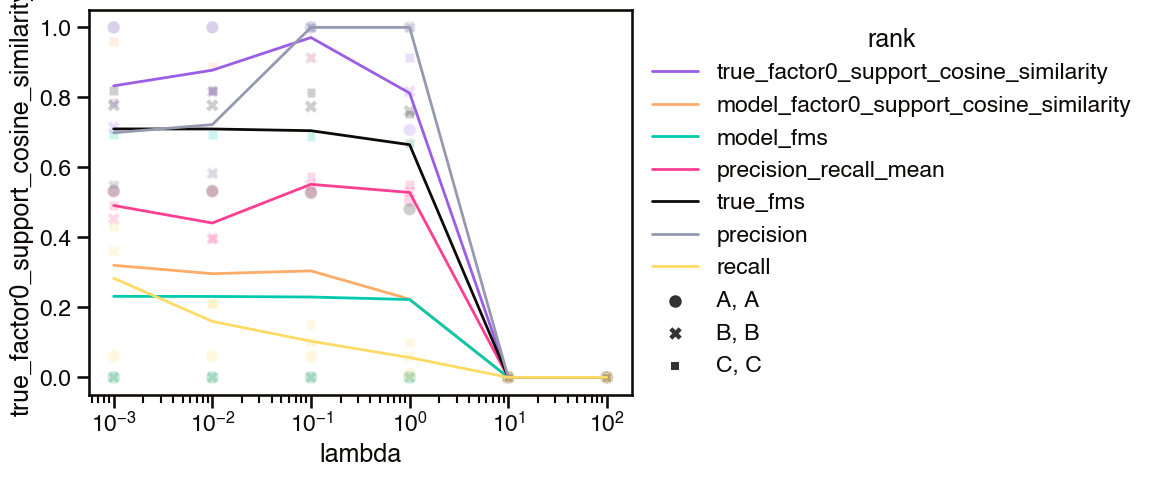

In [161]:
# look at fms against true factors vs lambda

y_vals = ['true_factor0_support_cosine_similarity', 
          'model_factor0_support_cosine_similarity', 
          'model_fms', 
          'precision_recall_mean', 'true_fms', 
          'precision', 'recall']
# y_val = 'precision_recall_mean'

plot_df = sim_df[sim_df['lambda'] != 0]

fig, axis = plt.subplots(figsize=(7, 5))
for i, y_val in enumerate(y_vals):
    data_df = plot_df[plot_df[y_val].notna()]
    sns.lineplot(
        x='lambda', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
#         color=sns.color_palette()[i*2], 
        color=sns.color_palette()[i], 
        ci=None, 
#         ci='sd', 
#         err_style='bars', 
        data=data_df,
        ax=axis, 
        label=y_val
    );
    sns.scatterplot(
        x='lambda', 
        y=y_val, 
        style='replicate_pair',
    #     hue='rank', 
#         color='black', 
#         color=sns.color_palette()[i*2], 
        color=sns.color_palette()[i], 
        alpha=0.2, 
        data=data_df, 
        ax=axis, 
        legend=(i==len(y_vals)-1)
    );
plt.xscale('log', base=10);
plt.legend(title='rank', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_true_fms-v-lambda-by-rank.png'.format(sim_id), bbox_inches='tight')

In [ ]:
# look at factors of all optimal parameters decomposition

data_dir = Path('../data')
heatmap_params = {'vmin':None, 'vmax':None, 'cmap':'coolwarm', 'center':0}

replicate = 'A'

rank = sim_df['optimal_rank'].unique()[0]
sparsity = 10.

#     rank = int(params['rank'])
#     sparsity = params['lambda']

# build filepaths of true cp and optimal decomposition
true_path = data_dir / 'sim{}'.format(
    sim_id, 
)
decomp_path = data_dir / 'sim{}/replicate{}/rank{}/lambda{}'.format(
    sim_id, 
    replicate, 
    rank, 
    sparsity
)

# load cps
true_cp = load_cp_tensor(true_path / 'simulation_ground_truth.h5')
cp = load_cp_tensor(decomp_path / 'fitted_model.h5')
print('\nSimulation {}: {}\n\tnoise level={:.2}\n\toptimal rank={}\n\toptimal lambda={}'.format(
    sim_id, 
    true_cp,
    sim_df['noise_level'].unique()[0], 
    rank, 
    sparsity
))

# calculate fms and get optimal permutation
fms, perm = factor_match_score(true_cp, cp, return_permutation=True, allow_smaller_rank=True)
cp_perm = tlviz.factor_tools.permute_cp_tensor(cp, perm)
print('\tFMS: {}'.format(fms))

# plot
fig, ax = plot_factors_heatmap(
    tl.cp_normalize(cp_perm).factors, 
    reference_factors=tl.cp_normalize(true_cp).factors, 
    mask_thold=[0, 0], 
    ratios=False, 
    heatmap_kwargs=heatmap_params)
plt.show()


In [ ]:
# look at relative_sse vs rank

plot_df = sim_df[sim_df['modeled_replicate'] != sim_df['comparison_replicate']]
# plot_df = plot_df[plot_df['lambda'] >= 1.0]
# plot_df = plot_df[plot_df['rank'] >= 8]

y_val = 'relative_sse'

fig, axis = plt.subplots(figsize=(7, 5))
# for i, rank in enumerate(df['rank'].unique()):
for i, lamb in enumerate(plot_df['lambda'].unique()):
#     data_df = plot_df[plot_df['rank'] == rank]
    data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
#         label=rank
        label=lamb
    );
#     sns.scatterplot(
# #         x='lambda', 
#         x='rank', 
#         y=y_val, 
#         style='replicate_pair',
#     #     hue='rank', 
# #         color='black', 
#         alpha=0.2, 
#         color=sns.color_palette()[i], 
#         data=data_df, 
#         ax=axis, 
#         legend=False
#     );
# plt.xscale('log', base=2);
# plt.yscale('log', base=10)
plt.legend(title='sparsity', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_relative_sse-v-rank-by-lambda.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at relative_sse vs lambda

plot_df = sim_df[sim_df['modeled_replicate'] != sim_df['comparison_replicate']]
# plot_df = plot_df[plot_df['rank'] >= 5]
# plot_df = plot_df[plot_df['lambda'] <= 1.0]

fig, axis = plt.subplots(figsize=(7, 5))
for i, rank in enumerate(plot_df['rank'].unique()):
    data_df = plot_df[plot_df['rank'] == rank]
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
        label=rank
    );
#     sns.scatterplot(
#         x='lambda', 
#         y='relative_sse', 
#         style='replicate_pair',
#     #     hue='rank', 
# #         color='black', 
#         alpha=0.2, 
#         color=sns.color_palette()[i], 
#         data=data_df, 
#         ax=axis, 
#         legend=False
#     );
plt.xscale('log', base=10);
plt.legend(title='rank', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_relative_sse-v-lambda-by-rank.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at fms (between replicates) vs lambda

y_val = 'model_fms'
plot_df = sim_df[sim_df[y_val].notna()]
# plot_df = plot_df[plot_df['lambda'] < 1]
# plot_df = plot_df[plot_df['rank'] == optimal_rank]


fig, axis = plt.subplots(figsize=(7, 5))
subsets = plot_df['rank'].unique()
for i, rank in enumerate(subsets):
    data_df = plot_df[plot_df['rank'] == rank]
    sns.lineplot(
        x='lambda', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci=None, 
#         ci='sd', 
#         err_style='bars', 
        data=data_df,
        ax=axis, 
        label=rank
    );
    sns.scatterplot(
        x='lambda', 
        y=y_val, 
        style='replicate_pair',
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        alpha=0.2, 
        data=data_df, 
        ax=axis, 
        legend=(i==len(subsets)-1)
    );
plt.xscale('log', base=10);
plt.legend(title='rank', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_model_fms-v-lambda-by-rank.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at fms (between replicates) vs rank

plot_df = sim_df[sim_df['modeled_replicate'] != sim_df['comparison_replicate']]

y_val = 'model_fms'

fig, axis = plt.subplots(figsize=(7, 5))
# for i, rank in enumerate(df['rank'].unique()):
for i, lamb in enumerate(plot_df['lambda'].unique()):
#     data_df = plot_df[plot_df['rank'] == rank]
    data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
#         label=rank
        label=lamb
    );
    sns.scatterplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
        style='replicate_pair',
    #     hue='rank', 
#         color='black', 
        alpha=0.2, 
        color=sns.color_palette()[i], 
        data=data_df, 
        ax=axis, 
        legend=False
    );
# plt.xscale('log', base=2);
# plt.yscale('log', base=10)
plt.legend(title='sparsity', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_model_fms-v-rank-by-lambda.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at n_components vs lambda

plot_df = sim_df[sim_df['modeled_replicate'] == sim_df['comparison_replicate']]
# plot_df = plot_df[plot_df['lambda'] < .1]

fig, axis = plt.subplots(figsize=(7, 5))
subsets = plot_df['rank'].unique()
for i, rank in enumerate(subsets):
    data_df = plot_df[plot_df['rank'] == rank]
    sns.lineplot(
        x='lambda', 
        y='n_components', 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
        label=rank
    );
    sns.scatterplot(
        x='lambda', 
        y='n_components', 
        style='replicate_pair',
    #     hue='rank', 
#         color='black', 
        alpha=0.2, 
        color=sns.color_palette()[i], 
        data=data_df, 
        ax=axis, 
        legend=(i==len(subsets)-1)
    );
plt.xscale('log', base=10);
plt.legend(title='rank', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_n_components-v-lambda-by-rank.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at mean_gene_sparsity vs lambda

plot_df = sim_df[sim_df['modeled_replicate'] == sim_df['comparison_replicate']]
# plot_df = plot_df[plot_df['lambda'] < .1]
plot_df = plot_df[plot_df['lambda'] != 0.0]

fig, axis = plt.subplots(figsize=(7, 5))
subsets = plot_df['rank'].unique()
for i, rank in enumerate(subsets):
    data_df = plot_df[plot_df['rank'] == rank]
    sns.lineplot(
        x='lambda', 
        y='mean_gene_sparsity', 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
        label=rank
    );
    sns.scatterplot(
        x='lambda', 
        y='mean_gene_sparsity', 
        style='replicate_pair',
    #     hue='rank', 
#         color='black', 
        alpha=0.2, 
        color=sns.color_palette()[i], 
        data=data_df, 
        ax=axis, 
        legend=False
    );
plt.xscale('log', base=10);
# plt.yscale('log', base=10)
plt.legend(title='rank');
# plt.savefig('../figures/sim{}_mean_gene_sparsity-v-lambda-by-rank.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at fms against true factors vs rank

y_val = 'true_fms'
plot_df = sim_df[sim_df['modeled_replicate'] == sim_df['comparison_replicate']]
# plot_df = plot_df[plot_df['lambda'] <= 1.0]

fig, axis = plt.subplots(figsize=(7, 5))
# for i, rank in enumerate(df['rank'].unique()):
for i, lamb in enumerate(plot_df['lambda'].unique()):
#     data_df = plot_df[plot_df['rank'] == rank]
    data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
#         label=rank
        label=lamb
    );
    sns.scatterplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
        style='modeled_replicate',
    #     hue='rank', 
#         color='black', 
        alpha=0.2, 
        color=sns.color_palette()[i], 
        data=data_df, 
        ax=axis, 
        legend=False
    );
# plt.xscale('log', base=2);
# plt.yscale('log', base=10)
plt.legend(title='sparsity', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_true_fms-v-rank-by-lambda.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at the cosine similarity of the modeled gene factors against the true gene factors vs rank

y_val = 'true_factor0_support_cosine_similarity'
plot_df = sim_df[sim_df['modeled_replicate'] == sim_df['comparison_replicate']]
# plot_df = plot_df[plot_df['lambda'] <= 1.0]

fig, axis = plt.subplots(figsize=(7, 5))
# for i, rank in enumerate(df['rank'].unique()):
for i, lamb in enumerate(plot_df['lambda'].unique()):
#     data_df = plot_df[plot_df['rank'] == rank]
    data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
#         label=rank
        label=lamb
    );
    sns.scatterplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
        style='modeled_replicate',
    #     hue='rank', 
#         color='black', 
        alpha=0.2, 
        color=sns.color_palette()[i], 
        data=data_df, 
        ax=axis, 
        legend=False
    );
# plt.xscale('log', base=2);
# plt.yscale('log', base=10)
plt.legend(title='sparsity', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_true_f0_support_cossim-v-rank-by-lambda.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at the cosine similarity of the modeled gene factors against the true gene factors vs rank

y_val = 'true_factor0_cosine_similarity'
# y_val = 'model_fms'
plot_df = sim_df[sim_df[y_val].notna()]

fig, axis = plt.subplots(figsize=(7, 5))
subsets = plot_df['rank'].unique()
for i, rank in enumerate(subsets):
    data_df = plot_df[plot_df['rank'] == rank]
    sns.lineplot(
        x='lambda', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci=None, 
#         ci='sd', 
#         err_style='bars', 
        data=data_df,
        ax=axis, 
        label=rank
    );
    sns.scatterplot(
        x='lambda', 
        y=y_val, 
        style='replicate_pair',
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        alpha=0.2, 
        data=data_df, 
        ax=axis, 
        legend=(i==len(subsets)-1)
    );
plt.xscale('log', base=10);
plt.legend(title='rank', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_true_f0_support_cossim-v-lambda-by-rank.png'.format(sim_id), bbox_inches='tight')


In [ ]:
for sim_id in [1, 4, 5, 6, 8]:
    for rank in [3, 5, 7]:
        for sparsity in [0.1, 1.0, 10.0]:
            decomp_path = data_dir / 'sim{}/replicate{}/rank{}/lambda{}'.format(
                    sim_id, 
                    'A', 
                    rank, 
                    sparsity
                )
            cp = load_cp_tensor(decomp_path / 'fitted_model.h5')
            print('\nSimulation {}: {}'.format(
                sim_id, 
                cp
            ))
            for mode in range(3):
                print(np.linalg.norm(cp.factors[mode], axis=0))

# Look at specific decompositions

In [ ]:
# look at factors of all optimal parameters decomposition

data_dir = Path('../data')
heatmap_params = {'vmin':None, 'vmax':None, 'cmap':'coolwarm', 'center':0}

# # make dict of optimal parameters
# optimal_params = optimal_df.groupby('simulation_id')[
#     ['rank', 'lambda', 'noise_level']].mean().reset_index().to_dict('records')
# # iterate through them
# for params in optimal_params:
#     # get optimal parameters for each simulation


sim_id = 8
replicate = 'A'

rank = 4
sparsity = 1.

#     rank = int(params['rank'])
#     sparsity = params['lambda']

# build filepaths of true cp and optimal decomposition
true_path = data_dir / 'sim{}'.format(
    sim_id, 
)
decomp_path = data_dir / 'sim{}/replicate{}/rank{}/lambda{}'.format(
    sim_id, 
    replicate, 
    rank, 
    sparsity
)

# load cps
true_cp = load_cp_tensor(true_path / 'simulation_ground_truth.h5')
cp = load_cp_tensor(decomp_path / 'fitted_model.h5')
print('\nSimulation {}: {}\n\tnoise level={:.2}\n\toptimal rank={}\n\toptimal lambda={}'.format(
    sim_id, 
    true_cp,
#     params['noise_level'], 
    'na', 
    rank, 
    sparsity
))

# calculate fms and get optimal permutation
fms, perm = factor_match_score(true_cp, cp, return_permutation=True, allow_smaller_rank=True)
cp_perm = tlviz.factor_tools.permute_cp_tensor(cp, perm)
print('\tFMS: {}'.format(fms))

# plot
fig, ax = plot_factors_heatmap(
    tl.cp_normalize(cp_perm).factors, 
    reference_factors=tl.cp_normalize(true_cp).factors, 
    mask_thold=[0, 0], 
    ratios=False, 
    heatmap_kwargs=heatmap_params)
plt.show()


In [ ]:
# look at similarity of sparsity supports

sup_true_cp = tl.cp_tensor.CPTensor((true_cp.weights, [(true_cp.factors[0] != 0)]))
# sup_true_cp = tl.cp_tensor.CPTensor((true_cp.weights, [true_cp.factors[0]]))
sup_cp = tl.cp_tensor.CPTensor((cp.weights, [(cp.factors[0] != 0)]))
# sup_cp = tl.cp_tensor.CPTensor((cp.weights, [cp.factors[0]]))

print(
    'cosine similarity factor0 support: {}'.format(
        tlviz.factor_tools.cosine_similarity(sup_true_cp.factors[0], sup_cp.factors[0])
    )
)
print(
    'cosine similarity factor0 values: {}'.format(
        tlviz.factor_tools.cosine_similarity(true_cp.factors[0], cp.factors[0])
    )
)


In [ ]:
# compare sparsity supports of gene factor to ground truth

# calculate fms and get optimal permutation
fms, perm = factor_match_score(true_cp, cp, return_permutation=True, allow_smaller_rank=True)
cp_perm = tlviz.factor_tools.permute_cp_tensor(cp, perm)
print(fms)

# plot
heatmap_params = {'vmin':None, 'vmax':None, 'cmap':'coolwarm', 'center':0}
fig, ax = plot_factors_heatmap(
    tl.cp_normalize(cp_perm).factors, 
    reference_factors=tl.cp_normalize(true_cp).factors, 
#     cp_perm.factors, 
#     reference_factors=sim.factors, 
    mask_thold=[0, 0], 
    ratios=False, 
    heatmap_kwargs=heatmap_params)
plt.show()
fig.savefig('../figures/cp_comparison_sim{}_rank{}_lambda{}.png'.format(sim_id, rank, sparsity))


In [ ]:
# compare decomposition factors to ground truth

# calculate fms and get optimal permutation
fms, perm = factor_match_score(true_cp, cp, return_permutation=True, allow_smaller_rank=True)
cp_perm = tlviz.factor_tools.permute_cp_tensor(cp, perm)
print(fms)

# plot
heatmap_params = {'vmin':None, 'vmax':None, 'cmap':'coolwarm', 'center':0}
fig, ax = plot_factors_heatmap(
    tl.cp_normalize(cp_perm).factors, 
    reference_factors=tl.cp_normalize(true_cp).factors, 
#     cp_perm.factors, 
#     reference_factors=sim.factors, 
    mask_thold=[0, 0], 
    ratios=False, 
    heatmap_kwargs=heatmap_params)
plt.show()
# fig.savefig('../figures/cp_comparison.png')


# Look at simulated data tensors

In [ ]:
# read in data

data_dir = Path('../../figure-1/data')

sim_id = 0
bootstrap = 0
replicate = 'A'

sim_path = data_dir / 'sim{}'.format(sim_id)


In [ ]:
# look at true ground truth tensor

true_cp = load_cp_tensor(sim_path / 'simulation_ground_truth.h5')
fig = visualize_3d_tensor(
    true_cp.to_tensor(), 
    shell=False, 
    midpoint=0, 
    range_color=[-1, 1]
)
fig.show()


In [ ]:
# look at replicate dataset

da = xr.open_dataarray(sim_path / 'replicate{}/simulation_data_replicate_{}.nc'.format(replicate, replicate))
fig = visualize_3d_tensor(
    da.data, 
    shell=False, 
    midpoint=0, 
    range_color=[-1, 1]
)
fig.show()


In [ ]:
# look at shuffled replicate data

rep_path = sim_path / 'bootstrap{}/replicate{}'.format(b, rep) 
rep_array = xr.open_dataarray(rep_path / 'shuffled_replicate_{}.nc'.format(rep))
fig = visualize_3d_tensor(
    rep_array.data, 
    shell=False, 
    midpoint=0, 
    range_color=[-1, 1]
)
fig.show()
